# Monte Carlo Method

Monte Carlo simulation to estimate the Value at Risk (VaR) of a portfolio composed of two financial assets.

**Description**
- We use Monte Carlo to generate multiple possible price evolution scenarios.
- We model price dynamics using Geometric Brownian Motion (GBM).
- We introduce correlation between the assets via the covariance matrix and the Cholesky decomposition.
- We compute Value at Risk (VaR) to measure the maximum expected 1-day loss at different confidence levels.

**Objectives**
- Assess portfolio risk while accounting for uncertainty in asset prices.
- Obtain a distribution of possible changes in portfolio value and determine the associated VaR.


In [2]:
# Monte Carlo Method
# Import the libraries needed for our simulation.
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

C:\Users\miralles\AppData\Roaming\Python\Python313\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import gaussian_kde


## Define simulation parameters

We set the parameters for the Monte Carlo simulation, including the assets to analyze,  
the number of shares in the portfolio, the historical data period, and the number of simulations.

**Parameters**
- **RISKY_ASSETS**: Selected assets (Goldman Sachs and JPMorgan Chase).  
- **SHARES**: Number of shares of each asset in the portfolio.  
- **START_DATE / END_DATE**: Historical period used to estimate parameters.  
- **T**: Investment horizon in years.  
- **N_SIMS**: Number of Monte Carlo simulations to run.  

In [1]:
# Define simulation parameters
RISKY_ASSETS = ["GS", "JPM"]  # Goldman Sachs and JPMorgan Chase
SHARES = [5, 5]  # Number of shares of each asset
START_DATE = "2018-01-01"  # Start date
END_DATE = "2018-12-31"  # End date
T = 1  # Investment horizon in years
N_SIMS = 10**5  # Number of Monte Carlo simulations (100,000)

In [3]:
# Download historical data from Yahoo Finance
df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE, auto_adjust=True)

[*********************100%***********************]  2 of 2 completed


## Compute daily returns

We extract the adjusted closing prices and compute the daily returns.

⚠️ **Note**: For stock price simulations based on Geometric Brownian Motion (GBM),  
logarithmic returns are generally recommended over simple returns.

Recommended formula for log-returns:
```python
returns = np.log(1 + adj_close.pct_change())

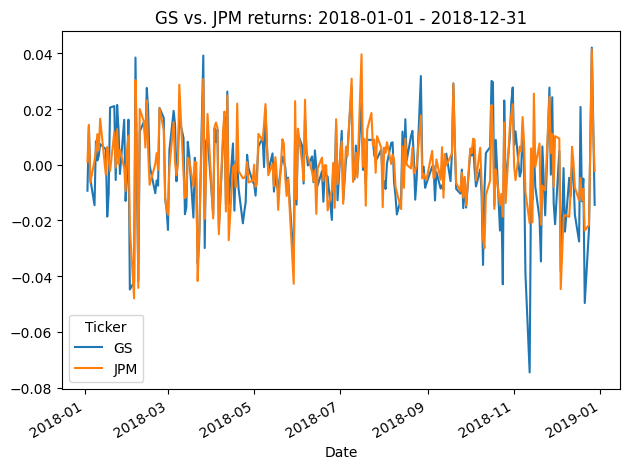

In [4]:
# Extract adjusted closing prices and compute daily returns
adj_close = df["Close"]  # Adjusted closing prices
returns = adj_close.pct_change()  # Simple daily returns
returns = returns.dropna()  # Drop missing values

# Plot risky asset returns
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)
plt.tight_layout()
plt.show()

In [5]:

# Compute correlation between assets
correlation = returns.corr().values[0, 1]
print(f"Correlation between returns: {correlation:.2f}")


Correlation between returns: 0.80


## Compute covariance matrix

The covariance matrix measures the joint variability of the portfolio assets’ returns.  

We will use this matrix in the next step to generate correlated random numbers for the simulation,  
through the Cholesky decomposition.

In [6]:
# Compute covariance matrix of historical returns
cov_mat = returns.cov()

print("Covariance matrix:")
print(cov_mat)

Covariance matrix:
Ticker        GS       JPM
Ticker                    
GS      0.000260  0.000181
JPM     0.000181  0.000195


## Cholesky decomposition

The Cholesky decomposition factors a symmetric positive-definite matrix into a lower-triangular matrix  
and its transpose:

$$
\Sigma = L \cdot L^T
$$

Where:  
- **Σ**: Covariance matrix of asset returns  
- **L**: Lower-triangular matrix  

**Purpose:**  
Transform independent random numbers into correlated ones.


In [7]:
# Cholesky decomposition
chol_mat = np.linalg.cholesky(cov_mat)

print("Cholesky decomposition:")
print(chol_mat)

Cholesky decomposition:
[[0.01613662 0.        ]
 [0.01118994 0.00835249]]


## Generate correlated random numbers from the standard Normal distribution

For Monte Carlo simulation we need random values to model the future uncertainty of asset returns.  
These random values must incorporate the historical correlation between the assets in our portfolio.

**Steps:**
1. Generate random numbers from a standard Normal distribution.  
2. Apply the Cholesky decomposition to introduce historical correlation.  

This ensures simulations that respect the historical correlation structure between the assets.

In [8]:
# Generate independent random numbers
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))

# Introduce correlation using the Cholesky decomposition
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

## Compute metrics required for the simulations

Before running the Monte Carlo simulation, we calculate key parameters based on the historical data of the assets.

**Parameters computed:**
- **r**: Expected return of each asset (mean of historical returns).  
- **sigma**: Volatility of each asset (standard deviation of returns).  
- **S₀**: Last adjusted closing price of each asset.  
- **P₀**: Current total portfolio value (price of each asset × number of shares).  

These values are used in the simulation to project the future behavior of the assets.

In [9]:
# Compute parameters for simulation
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)


## Simulate future asset prices

We use a Geometric Brownian Motion (GBM) model to project future asset prices.

**Formula:**

$$
S_T = S_0 \cdot \exp \Big( (r - 0.5 \cdot \sigma^2) \cdot T + \sigma \cdot \sqrt{T} \cdot Z \Big)
$$

Where:  
- **S_T**: Simulated future asset price.  
- **S₀**: Current closing price.  
- **r**: Expected return of the asset.  
- **σ**: Asset volatility.  
- **T**: Time horizon in years.  
- **Z**: Correlated standard Normal random variable.  

This model generates multiple possible price paths for the assets.

In [10]:
# Simulate future asset prices using GBM
S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * correlated_rv)

## Compute future portfolio value and changes

After simulating future asset prices, we calculate the portfolio’s future value in each simulation  
and its difference relative to the current value.

**Calculations:**
- **P_T**: Future portfolio value (sum of each simulated asset value × number of shares).  
- **P_diff**: Change in portfolio value relative to the initial value.  

These values allow us to analyze the distribution of possible gains and losses in the simulated scenarios.

In [11]:
# Compute future portfolio value and changes
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

## Compute Value at Risk (VaR)

We calculate the Value at Risk (VaR), which represents the maximum expected loss at a given confidence level.

**Steps:**
1. Sort the simulated changes in portfolio value.  
2. Extract the corresponding percentiles.  

In [12]:
# Compute Value at Risk (VaR)
P_diff_sorted = np.sort(P_diff)  # Sort portfolio value changes
percentiles = [0.01, 0.1, 1.0]   # VaR confidence levels
var = np.percentile(P_diff_sorted, percentiles)  # Compute VaR

# Print VaR results
for x, y in zip(percentiles, var):
    print(f"1-day VaR with {100-x}% confidence: {-y:.2f}$")

1-day VaR with 99.99% confidence: 2.27$
1-day VaR with 99.9% confidence: 2.11$
1-day VaR with 99.0% confidence: 1.93$


## Plot distribution of portfolio value changes

We plot the distribution of simulated 1-day portfolio value changes to visualize the potential variability in a single day.

**Plot elements:**
- Histogram of portfolio changes with kernel density estimate.  
- Red dashed line indicating the 99% confidence VaR.  

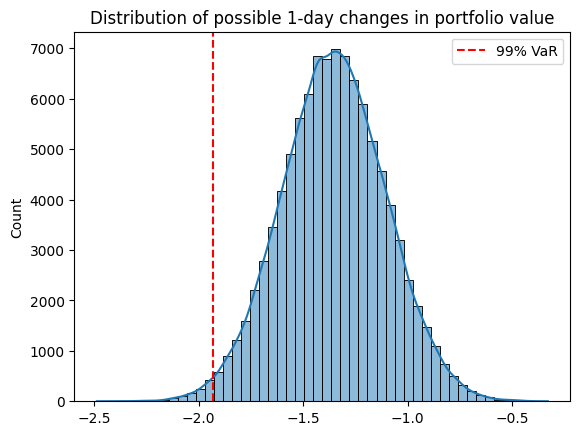

In [13]:
# Plot distribution of portfolio value changes
sns.histplot(P_diff, bins=50, kde=True)  # Histogram of portfolio changes
plt.axvline(var[2], color="red", linestyle="dashed", label="99% VaR")  # 99% VaR line
plt.legend()
plt.title("Distribution of possible 1-day changes in portfolio value")
plt.show()